# Get all geolocations of each station

not found Bahnhofquai/HB
not found Messe/Hallenstadion
not found Bahnhofstrasse/HB
not found ETH/Universitätsspital
not found Sihlquai/HB
not found Messe/Hallenstadion
not found Messe/Hallenstadion
not found Bahnhof Glattbrugg
not found Bahnhof Wallisellen
not found Bahnhof Balsberg
not found Sihlpost/HB
not found Bahnhofquai/HB
not found Bahnhofstrasse/HB
not found Sihlquai/HB
not found Sihlpost/HB
not found Kalkbreite/Bhf. Wiedikon
not found Kalkbreite/Bhf. Wiedikon
not found ETH/Universitätsspital
not found ETH/Universitätsspital
not found Messe/Hallenstadion
not found Bahnhof Wallisellen
not found Bahnhof Balsberg
not found Renggerstrasse
not found Kesslerplatz
not found Brunnenhof
not found Brunnenhof
not found Bahnhofplatz/HB
not found Bahnhofplatz/HB
not found Bahnhof Enge/Bederstrasse
not found Bahnhof Enge/Bederstrasse
not found Renggerstrasse
not found Bahnhof Wollishofen/Staubstrasse
not found Bahnhof Wollishofen/Staubstrasse
not found Bahnhof Glattbrugg
not found Schlieren 

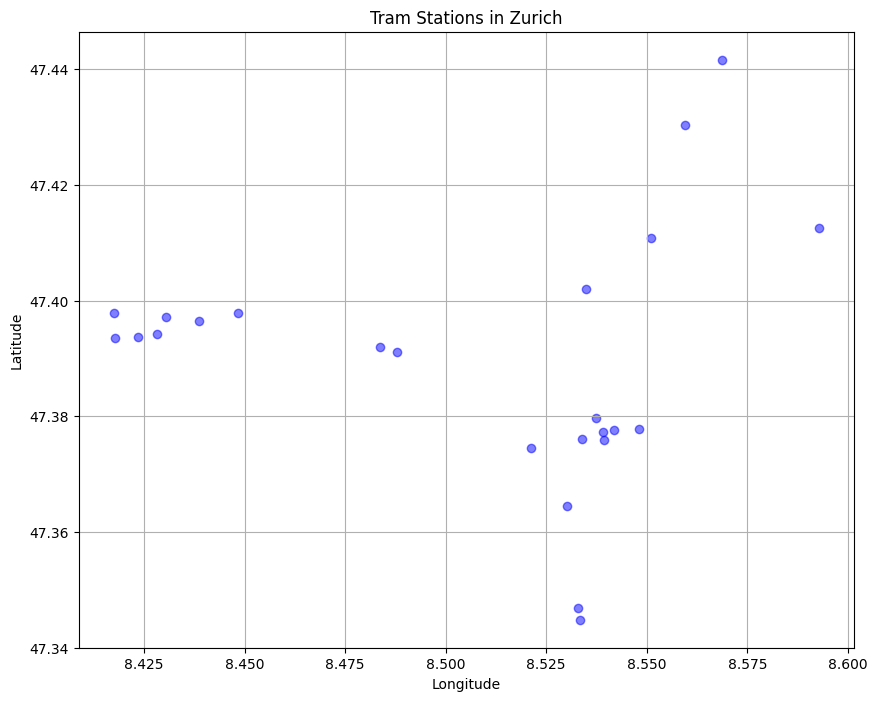

Tram stations data saved to 'tram_stations.json'


In [21]:
import pandas as pd
import overpy
import matplotlib.pyplot as plt
import json
from decimal import Decimal

# read in all station names fro DataInput/AllStationNames.json
with open('DataInput/AllStationNames.json') as f:
    all_station_names = json.load(f)

# Initialize the Overpass API
api = overpy.Overpass()

# Define the bounding box for Zurich (southwest and northeast corners)
min_lat, min_lon = 47.330698, 8.415097  # Southwest corner
max_lat, max_lon = 47.442737, 8.643750  # Northeast corner

# Create the Overpass query to get all tram stops in Zurich
query = f"""
(
  node["railway"="tram_stop"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["railway"="tram_stop"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["railway"="tram_stop"]({min_lat},{min_lon},{max_lat},{max_lon});
);
out center;
"""

# Run the query
result = api.query(query)

# Extract data
data = []
for element in result.nodes + result.ways + result.relations:
    name = element.tags.get("name")
    if name:
        # Check if the station name is in the list of all station names
        if name in all_station_names:
            continue
        else:
            print("not found", name)
        # For ways and relations, use the center point
        if hasattr(element, 'center_lat'):
            lat = float(element.center_lat)
            lon = float(element.center_lon)
        else:
            lat = float(element.lat)
            lon = float(element.lon)
        data.append({"station": name, "lat": lat, "lng": lon})

# Convert to DataFrame
df = pd.DataFrame(data)

# Remove duplicates based on station names
df = df.drop_duplicates(subset='station')

# Plot the station locations
plt.figure(figsize=(10, 8))
plt.scatter(df['lng'], df['lat'], marker='o', color='blue', alpha=0.5)
plt.title('Tram Stations in Zurich')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

# Create a dictionary in the specified structure
station_dict = df.set_index('station')[['lat', 'lng']].to_dict(orient='index')

# Custom encoder for Decimal
class DecimalEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Decimal):
            return float(obj)
        return super(DecimalEncoder, self).default(obj)

# Save the dictionary to a JSON file using the custom encoder
with open('tram_stations.json', 'w') as f:
    json.dump(station_dict, f, ensure_ascii=False, indent=4, cls=DecimalEncoder)

print("Tram stations data saved to 'tram_stations.json'")


In [17]:
# plot the locations on a folium map
import folium

# Create a map centered around Zurich
m = folium.Map(location=[47.3769, 8.5417], zoom_start=12)

# Add a marker for each station
for index, row in df.iterrows():
    if row['lat'] is not None:
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=row['station']
        ).add_to(m)
m